# 13 - Displaying Logging While Drilling (LWD) Image Logs in Python
  
**Created By:** Andy McDonald  
**Link to Article:** [Medium Article](https://andymcdonaldgeo.medium.com/displaying-logging-while-drilling-lwd-image-logs-in-python-4babb6e577ba) 
  
Borehole image logs are false-color pseudo images of the borehole wall generated from different logging measurements/tools. How borehole images are acquired differs between wireline logging and logging while drilling (LWD). In the wireline environment measurements are made from buttons on pads that are pressed up against the borehole wall and provide limited coverage, but at a high resolution. In contrast, in the LWD environment measurements are made from sensors built into tools that form part of the drillstring/tool assembly, and using the tool rotation, provide full 360-degree coverage. LWD image data is often split into sectors, the number of which will vary depending on the tool technology. As the tool rotates the data is binned into the relevant sector and from it we can build up a pseudo image of the borehole wall. 


The generated images are often viewed in two dimensions on a log plot as an 'unwrapped borehole' and as seen in the image above. The cylindrical borehole is cut along the north azimuth in vertical wells or along the highside of the borehole in deviated/horizontal wells. As a result of being projected onto a 2D surface, any planar features that intersect the borehole are represented as sinusoid shapes on the plot. By analyzing the amplitude and offset of these sinusoids geologists can gain an understanding of the geological structure of the subsurface. Borehole image data can also be used to identify and classify different geological facies/textures, identify thin-beds, fault  and fracture analysis, and more. 


In this article, I am going to work through displaying logging while drilling image data from azimuthal gamma ray and azimuthal density measurements using Python and matplotlib. 
This article forms part of my Python & Petrophysics series. Details of which can be found here. For the examples below you can find my Jupyter Notebook and dataset on my GitHub repository at the following link.

### Setting up The Libraries and Loading Data
Before we begin working with our data we will need to import a number of libraries for us to work with. For this article, we will be using pandas, matplotlib, numpy and  lasio libraries. These three libraries allow us to load our las data, work with it and create visualizations of the data.

In [1]:
import lasio
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Importing Well and Survey Data
The dataset we are using comes from the publicly accessible Netherlands NLOG database. The las file contains a mixture of LWD measurements and two images. As las files are flat and don't support arrays, LWD image data is often delivered as individual sectors. The second file we will load is the survey, this allows us to understand the deviation and azimuth of the wellbore and is useful for calculating accurate formation dips. We will not be covering dip picking in this article.

We will first load the las file using lasio and convert it to a dataframe using `.df()`.

In [2]:
las = lasio.read('Data/P11-A-02_Composite_MEM_Image_NF.las')

In [3]:
df = las.df()

Once the data has been loaded, we can confirm the data that we have by using `df.describe()`. As there is a large number of curves present within the file, we can call upon `df.columns()` to view the full list of curves present:

In [4]:
df.describe()

,APRESM,GRAFM,RACELM,RPCELM,RACEHM,RPCEHM,RACESLM,RPCESLM,RACESHM,RPCESHM,...,ABDCM,GRAS0M,GRAS1M,GRAS2M,GRAS3M,GRAS4M,GRAS5M,GRAS6M,GRAS7M,GRASM
count,7360.000000,7355.000000,6917.000000,7344.000000,7344.000000,7344.000000,7344.000000,6917.000000,6917.000000,6917.000000,...,7113.000000,7208.000000,7208.000000,7208.000000,7208.000000,7208.000000,7208.000000,7208.000000,7208.000000,7208.000000
mean,3356.539266,68.686595,50.228085,10.718265,60.545421,115.370545,91.423746,13.394316,10.100346,24.916993,...,2.293634,65.939388,66.174622,66.703783,67.207081,67.071850,66.457910,66.211155,66.158664,56.899249
std,177.783894,26.364287,230.932561,8.165431,557.500476,2298.892852,286.731383,250.648696,91.689085,546.377461,...,0.239665,26.894019,27.042071,28.012537,29.263270,29.108535,28.319111,27.556459,27.358088,28.263808
min,2995.000000,19.393900,-0.795000,0.070000,0.077300,1.880100,0.025700,0.071900,-0.006100,0.066300,...,1.746100,4.737800,8.014500,3.787600,7.167100,11.402200,8.316300,9.168800,8.235400,1.873500
25%,3205.000000,45.084050,5.156800,4.343300,4.250775,4.865100,4.185800,4.357400,4.347700,4.068700,...,2.254500,44.847050,44.653425,43.894800,43.342600,43.518025,43.595300,44.303925,44.588825,37.778400
50%,3359.000000,59.658400,7.814100,7.845000,6.807500,9.730800,6.763750,7.113100,5.968400,8.121700,...,2.305700,56.966500,57.470850,57.583400,57.245050,57.939800,57.226400,57.214500,57.063750,49.315950
75%,3527.250000,90.122600,11.800800,14.483400,11.831400,20.380475,11.801950,13.744500,10.184200,17.879800,...,2.335900,86.345950,85.768000,87.380900,89.057750,88.184625,87.221550,86.434325,86.144750,73.171625
max,3652.000000,144.427800,2190.315700,41.615100,6186.146500,60467.757800,1636.078000,20227.576200,4145.540000,25521.566400,...,6.193600,154.516200,169.054200,167.009800,176.773400,174.270400,170.427300,160.418900,174.238800,174.270400


In [5]:
df.columns

Index(['APRESM', 'GRAFM', 'RACELM', 'RPCELM', 'RACEHM', 'RPCEHM', 'RACESLM',
       'RPCESLM', 'RACESHM', 'RPCESHM', 'RPTHM', 'NPCKLFM', 'DPEFM', 'BDCFM',
       'DRHFM', 'TVD', 'BLOCKCOMP', 'INNM', 'ROP_AVG', 'WOB_AVG', 'TCDM',
       'ABDCUM', 'ABDCLM', 'ABDCRM', 'ABDCDM', 'ABDC1M', 'ABDC2M', 'ABDC3M',
       'ABDC4M', 'ABDC5M', 'ABDC6M', 'ABDC7M', 'ABDC8M', 'ABDC9M', 'ABDC10M',
       'ABDC11M', 'ABDC12M', 'ABDC13M', 'ABDC14M', 'ABDC15M', 'ABDC16M',
       'ABDCM', 'GRAS0M', 'GRAS1M', 'GRAS2M', 'GRAS3M', 'GRAS4M', 'GRAS5M',
       'GRAS6M', 'GRAS7M', 'GRASM'],
      dtype='object')

As explained in the introduction, we can see the azimuthal density image is split into 16 individual sectors labeled ABDC1M to ABDC16M. The azimuthal gamma ray image is split into 8 sectors and labeled GRAS0M to GRAS7M.

The survey data is contained within a csv file and can be loaded as follows.

In [6]:
survey = pd.read_csv('Data/P11-A-02_SURV.csv')
survey.columns

Index(['DEPTH', 'DEVI', 'AZIM'], dtype='object')

When we read the columns from the dataframe we find we have three curves present: measured depth (DEPTH), hole deviation (DEVI), and hole azimuth (AZIM). We will be using these curves for additional visualization on our plot.


Before we plot the data, we will make the data simpler to handle by splitting it the main dataframe into two smaller ones for each image. We can achieve this by calling upon the dataframe (df) and supplying a list of curve names that we want to extract.

In [7]:
azidendf = df[['ABDC1M', 'ABDC2M', 'ABDC3M', 'ABDC4M', 'ABDC5M', 'ABDC6M', 'ABDC7M', 'ABDC8M', 'ABDC9M',
       'ABDC10M', 'ABDC11M', 'ABDC12M', 'ABDC13M', 'ABDC14M', 'ABDC15M',
       'ABDC16M']]

In [8]:
azigamdf = df[['GRAS0M', 'GRAS1M', 'GRAS2M', 'GRAS3M', 'GRAS4M',
       'GRAS5M', 'GRAS6M', 'GRAS7M']]

### Plotting the Image Data
#### Azimuthal Density Image
Plotting the image data is fairly straight forward. We first have to create a figure object using `plt.figure(figsize=(7,15))`. The figsize argument allows us to control the size, in inches, of our final plot.

We can also, optionally, create two new variables for our min and max depth. These are used to define the extent of the plotting area. As the index of our dataframe contains our depth values we can create two new variables `miny` and `maxy` that are equal to the minimum and maximum index values.

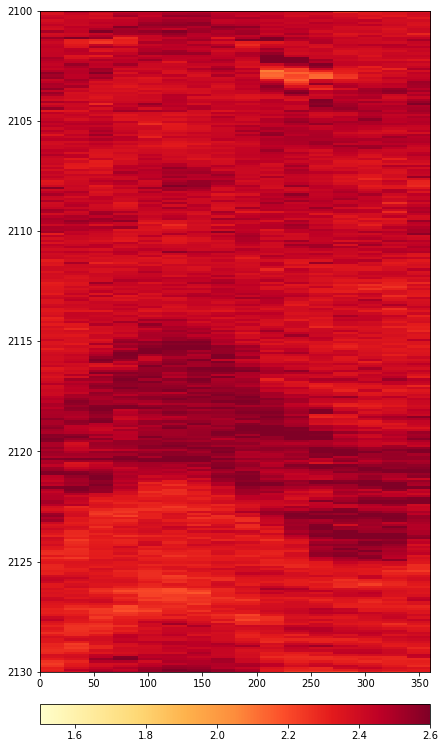

In [9]:
plt.figure(figsize=(7,15))
miny = azidendf.index.min()
maxy = azidendf.index.max()
plt.imshow(azidendf, interpolation='none',
           aspect='auto', cmap=plt.cm.YlOrRd,
           vmin=1.5, vmax=2.6,
          extent=[0, 360, maxy, miny])

plt.ylim(2130, 2100)

plt.colorbar(orientation='horizontal', pad =0.04)
plt.show()

When we execute the code we generate an image that shows us our features, but at the same time, we can see it is a bit blocky looking. If you look close enough you will be able to make out the individual sectors for the image.

We can apply some interpolation to the image and smooth it out. In the example below, the interpolation has been changed to bilinear.

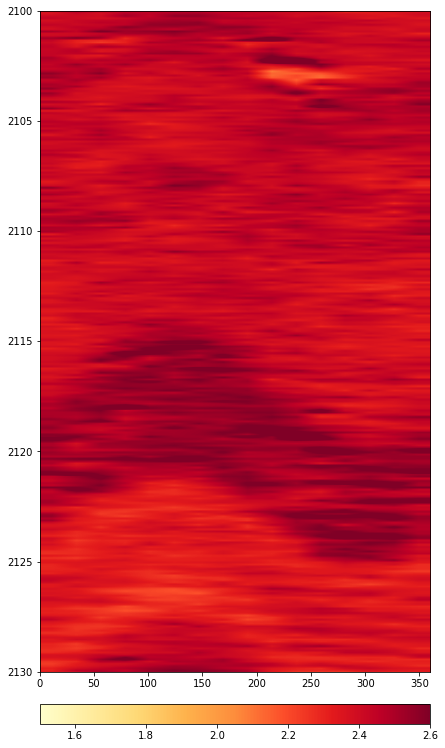

In [10]:
plt.figure(figsize=(7,15))
miny = azidendf.index.min()
maxy = azidendf.index.max()
plt.imshow(azidendf, interpolation='bilinear',
           aspect='auto', cmap=plt.cm.YlOrRd,
           vmin=1.5, vmax=2.6,
          extent=[0, 360, maxy, miny])

plt.ylim(2130, 2100)

plt.colorbar(orientation='horizontal', pad =0.04)
plt.show()

You can find a full list of options for interpolation available in the [matplitlib documentation](ttps://matplotlib.org/3.1.1/gallery/images_contours_and_fields/interpolation_methods.html). To illustrate the different methods, I have used the code from the documentation to generate a grid show the different options.

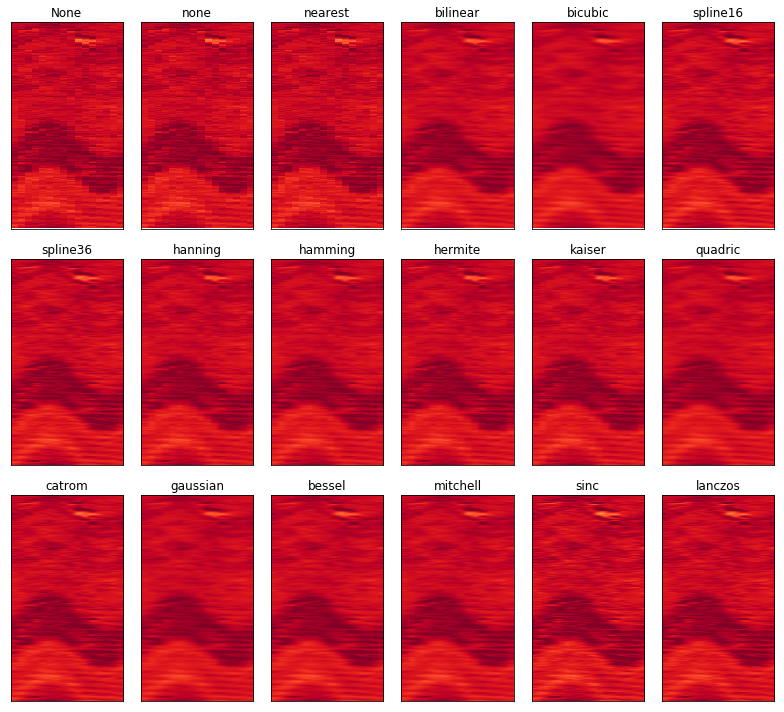

In [11]:
# Code Sourced from 
#https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/interpolation_methods.html


methods = [None, 'none', 'nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(11, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, interp_method in zip(axs.flat, methods):
    ax.imshow(azidendf, interpolation=interp_method,
           aspect='auto', cmap=plt.cm.YlOrRd,
           vmin=1.5, vmax=2.6,
          extent=[0, 360, maxy, miny])
    ax.set_title(str(interp_method))
    ax.set_ylim(2130, 2100)

plt.tight_layout()
plt.show()

You can see from the image above that some (lanczos and sinc) appear slightly sharper than the others. The choice will ultimately be down to user preference when working with the image data.

#### Azimuthal Gamma Ray Image
We can repeat the above code, by change the data frame from azidendf to azigamdf to generate our Azimuthal Gamma Ray image.

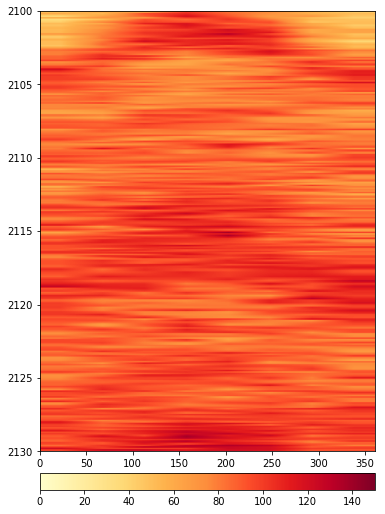

In [12]:
plt.figure(figsize=(6,10))
miny = azigamdf.index.min()
maxy = azigamdf.index.max()
plt.imshow(azigamdf, interpolation='bilinear',
           aspect='auto', cmap=plt.cm.YlOrRd,
           vmin=0, vmax=150,
          extent=[0, 360, maxy, miny])

plt.ylim(2130, 2100)

plt.colorbar(orientation='horizontal', pad =0.04)
plt.show()

When we view our image, we notice that the level of detail is significantly less compared to the density image. This is related to the measurement type and the lower number of sectors being recorded.

### Building The Final Plot
We can now plot both our image logs together alongside the survey data using subplots. The `subplot2grid((1,3),(0,0))` method allows us to set up the shape of the plot, in this case, we are plotting 1 row and 3 columns. We then assign ax1, ax2, and ax3 to the three columns as denoted by the second set of numbers in the function. As we are plotting deviation on the same track as the azimuth we need to use `ax.twiny()` to add a new axis on top of an existing one.


To plot our image data, we can use the code in the previous sections for each of the images and instead of assigning it to a plot, we can assign them to subplot axes.

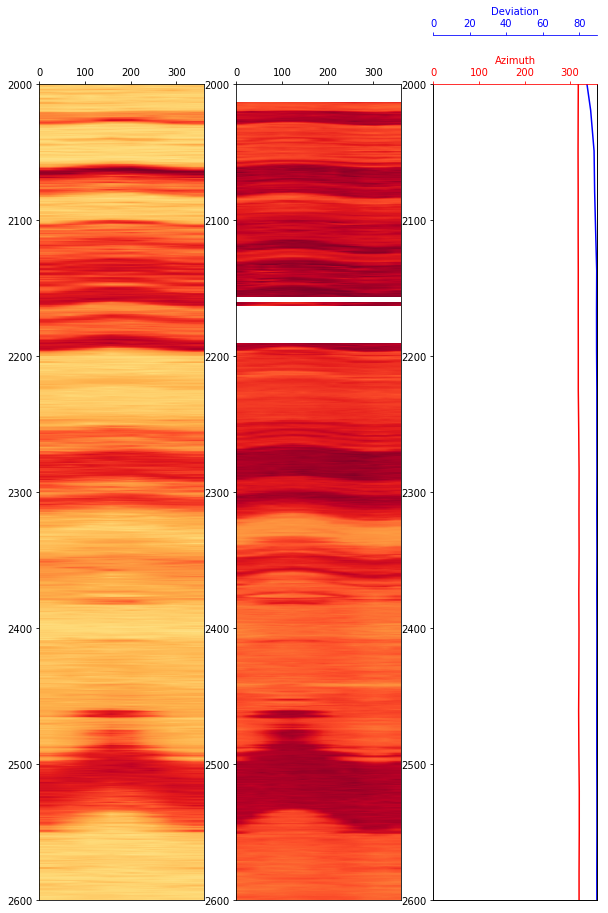

In [13]:
fig, ax = plt.subplots(figsize=(10, 15))

ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1))
ax3 = plt.subplot2grid((1,3),(0,2))
ax4 = plt.twiny(ax3)

ax1.imshow(azigamdf, interpolation='bilinear',
           aspect='auto', cmap=plt.cm.YlOrRd,
           vmin=0, vmax=150,
          extent=[0, 360, maxy, miny])

ax2.imshow(azidendf, interpolation='bilinear',
           aspect='auto', cmap=plt.cm.YlOrRd,
           vmin=1.5, vmax=2.6,
          extent=[0, 360, maxy, miny])


ax3.plot('DEVI', 'DEPTH', data=survey, color='blue')
ax3.set_xlim(0,90)
ax3.spines["top"].set_position(("axes", 1.06))
ax3.tick_params(axis='x', colors="blue")
ax3.spines["top"].set_edgecolor("blue")
ax3.set_xlabel('Deviation')
ax3.xaxis.label.set_color("blue")

ax4.plot('AZIM', 'DEPTH', data=survey, color='red')
ax4.set_xlim(0,360)
ax4.tick_params(axis='x', colors="red")
ax4.spines["top"].set_edgecolor("red")
ax4.set_xlabel('Azimuth')
ax4.xaxis.label.set_color("red")

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(2600, 2000)
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    
plt.show()

Now we can see both images together and we can also take into account our borehole deviation, which indicates that we are in a horizontal section. This is important to know, especially when calculating any dips from image logs.
You may notice that the bed at 2,500 appears to offset between the two plots and would warrant further investigation. This will not be covered in this article.

## Summary
This article has shown you how to load and display borehole image logs from LWD azimuthal gamma ray and density measurements. Once the data has been separated into their respective dataframes it is easy to pass them to the imshow() plot in matplotlib. From this image data geologists and petrophysicists can gain a better understanding of the geological makeup of the subsurface.